# Basic Health Investment in a Consumption-Saving Model

This notebook concerns the `BasicHealthConsumerType` in `HARK.ConsumptionSaving.ConsHealthModel`, representing agents who make decisions about consumption, saving, and investing in their health (or human) capital. They are subject to three forms of risk: wage rate uncertainty, capital depreciation uncertainty, and mortality risk.

In [1]:
# Import the basic health investment consumer class, as well as some basic tools
import numpy as np
import matplotlib.pyplot as plt
from time import time
from HARK.utilities import plot_funcs
from HARK.ConsumptionSaving.ConsHealthModel import BasicHealthConsumerType

## Background on the Model

`BasicHealthConsumerType` does not represent a "serious" model of health investment that should be used for structural estimation. Rather, it was made to demonstrate the principles of solving a dynamic stochastic optimization problem with multiple endogenous states and controls.

The model was originally adapted from the one in Ludwig and Schoen (Comp Econ 2018), for use by White (JEDC 2015). The version in White adds income and depreciation risk to the original Ludwig and Schoen model, and the model here very slightly adjusts how mortality works.

Dynamic optimization problems famously suffer from the "curse of dimensionality": for each additional state and/or control variable, the size of the problem grows *exponentially*. Moreover, the endogenous grid method (which greatly speeds up backward iteration) becomes more difficult to use, because the set of endogenous gridpoints generated by inverting the first order conditions are irregularly positioned-- they are incompatible with typical rectilinear interpolation.

Ludwig & Schoen demonstrated that Delaunay triangulation can be used to interpolate the irregular set of endogenous gridpoints. White presented a new interpolation method for handling the irregular gridpoints, relying on known relationships among them. The default solver for `BasicHealthConsumerType` uses the interpolation method from White, included in HARK as `HARK.interpolation.Curvilinear2DInterp`.

## Model Statement

Each period $t$, the agent experiences wage rate $\omega_t$ and health depreciation rate $\delta_t$. He observes his market resources $m_t$ and health capital level $h_t$, then makes a decision about spending on his his consumption $c_t$ and health investment $n_t$. Consumption yields utility with CRRA preferences, while health investment produces additional health capital. Health $h_t$ is valued for two reasons: it reduces the probability of death after each period, and it makes the agent more productive and hence earn more income.

The model can be expressed in Bellman form as follows:

$$
\begin{align}
v_t(m_t, h_t) &= \max_{c_t, n_t} U(c_t) + \beta S_t E [ v_{t+1}(m_{t+1}, h_{t+1}) ] ~~\text{s.t.} \\
H_t &= h_t + g(n_t), \\
a_t &= m_t - c_t - n_t, \\
D_t &= \phi_t / (1 + H_t), \\
S_t &= 1 - D_t, \\
h_{t+1} &= (1-\delta_{t+1}) H_t, \\
y_{t+1} &= \omega_{t+1} h_{t+1}, \\
m_{t+1} &= R_{t+1} a_t + y_{t+1}, \\
U(c) &= \frac{c^{1-\rho}}{1-\rho}, \\
g(n) &= (\gamma / \alpha) n^{\alpha}, \\
(\omega_{t+1}, \delta_{t+1}) &\sim F_{t+1}.
\end{align}
$$

As parametric restrictions on the current version of the solver, it is required that $rho < 1$ (so that utility is strictly positive for all $c > 0$) and $Prob(\omega=0) > 0$, so that zero income is always possible. Along with the basic restriction that $0 < \alpha < 1$ so that health production is increasing and concave, these conditions guarantee that the first order conditions are *necessary and sufficient* to characterize the optimal policy, and that they hold with equality. The requirement to have positive probability of zero income will be lifted soon, with a solver improvement.

## Characterizing the Solution

As is typical in HARK, each period of this model is solved using the endogenous grid method (EGM). The end-of-period states are post-investment health capital $H_t$ and retained assets $a_t$. Substituting the transition dynamics into the Bellman equation, the continuation value function is:

$\mathfrak{v}_t(a_t,H_t) \equiv \beta \left(1 - \phi_t / (1 + H_t) \right)  E \left[ v_{t+1}(R_{t+1} a_t + \omega_{t+1} (1-\delta_{t+1}) H_t, (1-\delta_{t+1}) H_t) \right]$.

The Bellman form of the problem can then be expressed as:

$$
\begin{align}
v_t(m_t, h_t) &= \max_{c_t, n_t} \frac{c_t^{1-\rho}}{1-\rho} + \mathfrak{v}_t(a_t,H_t) ~~\text{s.t.} \\
H_t &= h_t + (\gamma / \alpha) n_t^{\alpha}, \\
a_t &= m_t - c_t - n_t.
\end{align}
$$

In this representation of the model, all of the intertemporal transitions (including risk) have been wrapped up into the "gothic" value function, with only intratemporal dynamics remaining.

The first order conditions with respect to $c_t$ and $n_t$ are thus:

$$
\begin{align}
c_t^{-\rho} - \mathfrak{v}_t^a(a_t,H_t) &= 0, \\
(\gamma n_t^{\alpha-1}) \mathfrak{v}^H_t(a_t,H_t) - \mathfrak{v}_t^a(a_t,H_t) &= 0.
\end{align}
$$

Rearranging terms and solving for $c_t$ and $n_t$ yields:

$$
\begin{align}
c_t &= \mathfrak{v}_t^a(a_t,H_t)^{-1/\rho}, \\
n_t &= \left( \frac{\mathfrak{v}_t^a(a_t,H_t)}{\gamma \mathfrak{v}^H_t(a_t,H_t)} \right)^{1/(\alpha-1)}.
\end{align}
$$

Inverting the intraperiod dynamics, the endogenous gridpoints associated with these optimal controls are:

$$
\begin{align}
m_t &= a_t + c_t + n_t, \\
h_t &= H_t - g(n_t).
\end{align}
$$

To solve the model using the endogenous grid method, we must choose a grid of end-of-period states $(a_t, H_t)$, compute end-of-period marginal value for each (with respect to both dimensions), and then apply the solution above to generate combinations of decision-time states $(m_t, h_t)$ and controls $(c_t, n_t)$ that satisfy the first order conditions. The solution to the period $t$ problem is an interpolant over those points.

While the marginal value of end-of-period assets $\mathfrak{v}_t^a(\cdot)$ is straightforward, the marginal value of post-investment health $\mathfrak{v}_t^H(\cdot)$ is somewhat more complex. When $H_t$ is slightly increased, the agent is marginally more likely to survive because $D_t$ decreases, they will get more income in $t+1$ due to higher human capital, and they will be healthier in $t+1$ (yielding benefits further in the future). The expression for $\mathfrak{v}_t^H(\cdot)$ thus has three terms, but the math is omitted here for brevity.

## Inputs to the Solver

The solution to the terminal period $T$ is simple: the agent should consume all resources, $c_t = m_t$ and invest nothing in their health; the value function is simply $v_T(m_T,h_T) = U(m_T)$. Each non-terminal period of the basic health investment model is solved using the function `solve_one_period_ConsBasicHealth`. The following objects are passed to the solver for each non-terminal period (in addition to a representation of the successor period's solution); default values are provided:

| Param | Description | Code | Value | Constructed |
| :---: | --- | --- | --- | :---: |
| $\beta$ |Intertemporal discount factor  | $\texttt{DiscFac}$ | 0.95 | |
| $\rho$ |Coefficient of relative risk aversion | $\texttt{CRRA}$ | 0.5 | |
| $R_{t+1}$ | Risk free interest factor | $\texttt{Rfree}$ | 1.03 | |
| $\alpha$ | Exponent on health production function | $\texttt{HealthProdExp}$ | 0.35 | |
| $\gamma$ | Factor on health production function | $\texttt{HealthProdFac}$ | 1.0 | |
| $\phi_t$ | Maximum death probability (if $H_t=0$) | $\texttt{DieProbMax}$ | 0.5 | $\surd$ |
| $F_{t+1}$ | Joint dstn of wage and depreciation rates | $\texttt{ShockDstn}$ | * | $\surd$ |
| $\mathcal{A}$ | Grid of end-of-period assets | $\texttt{aLvlGrid}$ | * | $\surd$ |
| $\mathcal{H}$ | Grid of post-investment health | $\texttt{HLvlGrid}$ | * | $\surd$ |

Objects listed as "constructed" are not specified as raw parameters, but instead built by a constructor function.

By default, the distribution of wage rate $w$ is lognormal with a point mass for unemployment, specified with parameters `WageRteMean`, `WageRteStd`, `WageRteCount`, `UnempPrb`, and `IncUnemp`. The distribution of depreciation rate $\delta$ is uniform by default, specified with parameters `DeprRteMean`, `DeprRteSpread`, and `DeprRteCount`. The joint distribution of shocks is assumed to be independent.

The grid of end-of-period assets $\mathcal{A}$ has a default specification using the same constructor function as other HARK models, with the same inputs as usualt (`aXtraMin`, etc). The grid of post-investment health $\mathcal{H}$ has a default specification of being uniformly distributed between `hLvlMin` and `hLvlMax` with `hLvlCount` nodes. Note the (lack of) capitalization, which is intentional.

Maximum death probability $\phi_t$ could be manually set as an age-varying parameter, but by default it is constructed using "logistic polynomial" coefficients. The parameter `DieProbMaxCoeffs` is a list representing polynomial coefficients $(p_0, p_1, p_2, \cdots)$, and the maximum death probability at each model age $t$ is constructed as:

$\varphi_t = \sum_{k} p_k t^k, ~~~~~ \phi_t = (1 + \exp(-\varphi_t))^{-1}$.

This form ensures that `DieProbMax` is strictly between 0 and 1 for all $t < T$, and that an increase in $\varphi_t$ also increases $\phi_t$. By default, `DieProbMaxCoeffs = [0.0]`, corresponding to $\phi_t = 0.5$, as in the referenced papers.

# Example Model Solution

Let's solve *one* non-terminal period of the model and then plot the resulting set of interpolating nodes.

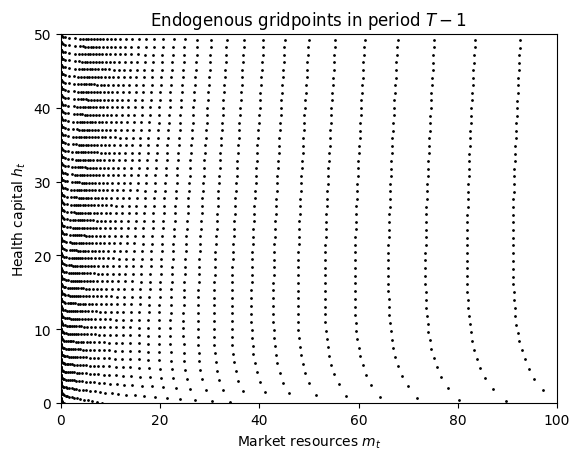

In [2]:
# Make and solve an example agent type with one non-terminal period
OnePeriodExample = BasicHealthConsumerType(cycles=1)
OnePeriodExample.solve()

# Plot the interpolation nodes of its solution
X = OnePeriodExample.solution[0].x_values
Y = OnePeriodExample.solution[0].y_values
plt.plot(X.flatten(), Y.flatten(), ".k", ms=2)
plt.xlim(0.0, 100.0)
plt.ylim(0.0, 50.0)
plt.xlabel(r"Market resources $m_t$")
plt.ylabel(r"Health capital $h_t$")
plt.title(r"Endogenous gridpoints in period $T-1$")
plt.show()

The solver for this model represents the one-period solution as a single interpolant with *three* function outputs (see below). The endogenous gridpoints are stored in the `x_values` and `y_values` attributes of this interpolant. When plotted, we can see that the $(m_t,h_t)$ gridpoints are not regularly spaced, even though $\mathcal{A} \times \mathcal{H}$ is an ordinary rectilinear grid.

To match what's done in the referenced papers, let's solve a total of 100 periods (99 non-terminal periods) and plot the gridpoints.

In [3]:
# Make an agent that lives for 100 periods and solve their problem; this will take a moment
BasicHealthExample = BasicHealthConsumerType(cycles=99)
t0 = time()
BasicHealthExample.solve()
t1 = time()
print(
    "Solving the basic health investment model took {:.3f}".format(t1 - t0)
    + " seconds."
)

Solving the basic health investment model took 48.767 seconds.


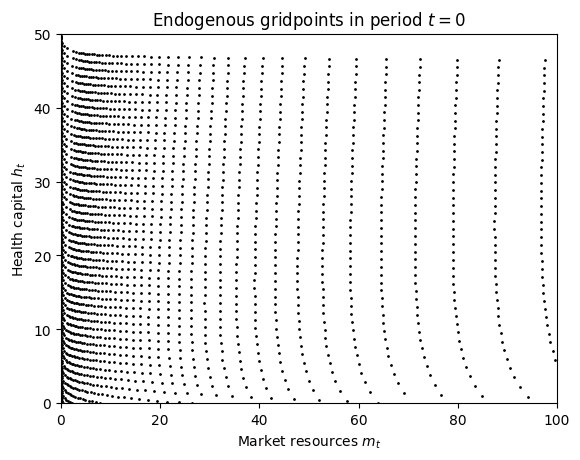

In [4]:
# Plot the interpolation nodes of its solution at t=0
X = BasicHealthExample.solution[0].x_values
Y = BasicHealthExample.solution[0].y_values
plt.plot(X.flatten(), Y.flatten(), ".k", ms=2)
plt.xlim(0.0, 100.0)
plt.ylim(0.0, 50.0)
plt.xlabel(r"Market resources $m_t$")
plt.ylabel(r"Health capital $h_t$")
plt.title(r"Endogenous gridpoints in period $t=0$")
plt.show()

Now let's plot some cross sections of its policy functions. In the cell below, the function output indexed by `[1]` is consumption and the output indexed by `[2]` is health investment.

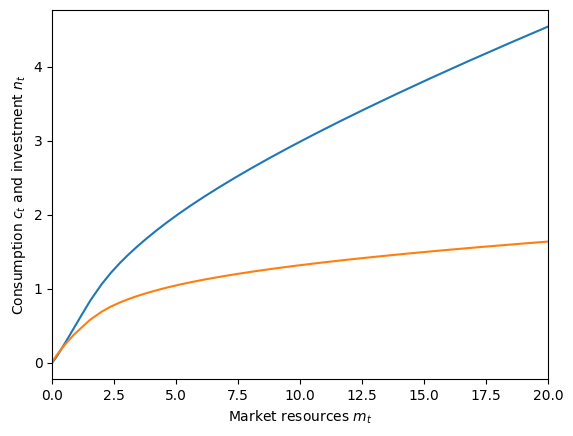

In [11]:
# Define cross sections of the consumption and health investment functions
t = 0
hLvl = 20.0
C = lambda mLvl: BasicHealthExample.solution[t](mLvl, hLvl * np.ones_like(mLvl))[1]
N = lambda mLvl: BasicHealthExample.solution[t](mLvl, hLvl * np.ones_like(mLvl))[2]

# Now plot them in a simple figure
plt.xlabel(r"Market resources $m_t$")
plt.ylabel(r"Consumption $c_t$ and investment $n_t$")
plot_funcs([C, N], 0.0, 20.0)